### Great stories and great visual effects

1. Set up a data science project structure in a new git repository in your GitHub account
2. Download any of the data sets from previous projects
3. Load the data set into panda data frames
4. Formulate one or two ideas on how storytelling and visualization would help describe the data set and establish additional value
5. Build three or more compelling visualizations
6. Document your process and results
7. Commit your notebook, source code, visualizations and other supporting files to the git repository in GitHub

In [1]:
#importing the required libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
nltk.download('stopwords')

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from joblib import dump, load
np.random.seed(6)

import seaborn as sns
sns.set()

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.manifold import TSNE
import pyLDAvis
pyLDAvis.enable_notebook()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/santoshkhatiwada/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Lets read the necessary csv files like movie, rating and tags.**

In [2]:
dfMovies = pd.read_csv('../data/ml-latest/movies.csv')
dfRating = pd.read_csv('../data/ml-latest/ratings.csv')
dfTags = pd.read_csv('../data/ml-latest/tags.csv')

**Since, many users have given different ratings for the same movie, lets calculate the average of the rating and use it as feature.**

In [3]:
dfFrmRating = dfRating.groupby('movieId')['rating'].mean().reset_index()


In [4]:
dfMoviesWithRatings = pd.merge(dfMovies, dfFrmRating, how='left', left_on=['movieId'], right_on=['movieId'])

**We can join the movie dataframe and rating dataframe using the column movieId.**

In [5]:
def tags(tag):
    totaltags = []
    for index, value in tag.iteritems():
        if(type(value)==str):
            totaltags.append(value)
    return '|'.join(totaltags)

selectedDfTags = dfTags
tags = (selectedDfTags.groupby('movieId')['tag'].apply(lambda x: tags(x)).reset_index())

tags.sort_values(by='movieId', ascending=True).head(10)

,movieId,tag
0,1,animated|buddy movie|Cartoon|cgi|comedy|comput...
1,2,fantasy|adapted from:book|animals|bad cgi|base...
2,3,moldy|old|Ann Margaret|Burgess Meredith|Daryl ...
3,4,characters|girl movie|characters|chick flick|b...
4,5,steve martin|steve martin|pregnancy|remake|agi...
5,6,overrated|bank robbery|crime|heists|relationsh...
6,7,Greg Kinnear|romance|Greg Kinnear|romance|base...
7,8,Disney|Library System|based on a book|Mark Twa...
8,9,Jean-Claude Van Damme|explosive|hostage|terror...
9,10,007|James Bond|Pierce Brosnan|Bob*ola|MTSKAF|b...


**As seen from the tags dataframe, one movie has multiple tags from different users. We can combine all the tags in same row for each movie.**

**We can combine the tags dataframe to the previous merged dataframe by using the same column movieId.**

In [6]:
dfMoviesRatingTags = pd.merge(dfMoviesWithRatings, tags, how='left', left_on=['movieId'], right_on=['movieId'])
dfMoviesRatingTags = dfMoviesRatingTags.dropna()
dfMoviesRatingTags = dfMoviesRatingTags.reset_index().drop('index',axis=1)
dfMoviesRatingTags.tail()

,movieId,title,genres,rating,tag
41767,193761,Bel Canto (2018),Drama|Thriller,1.50,concert|hostage|kidnapping|opera singer|rebel|...
41768,193811,Burning Shadow (2018),Thriller,2.00,doppelganger|Julie Delpy
41769,193837,Lily C.A.T. (1987),Animation|Horror|Sci-Fi,2.00,aliens|anime|cat|space marines|virus
41770,193864,No somos de piedra (1968),Comedy,2.50,Alfredo Landa|anticonception|comic|family|hous...
41771,193868,Dos tipos de cuidado (1953),Comedy|Drama|Romance|Western,4.25,black and white|comedy|friendship|fun|marriage...


**Lets do some exploratory data analysis to gain some insights about overall ratings, genres and tags.**

In [7]:
stop_words = stopwords.words('english')
cntVectorizer = CountVectorizer(binary=True, stop_words=stop_words, min_df=5, max_df=0.99,max_features=500,
                                analyzer=lambda x:x.split('|'))
#cntVectorizer = TfidfVectorizer(binary=False, stop_words=stop_words, min_df=5, max_df=0.99,max_features=500)
data = cntVectorizer.fit_transform(dfMoviesRatingTags['genres'])#fit makes a dictionary and transform 
                                                            #the words into values of dictionary.
genreVocab = cntVectorizer.get_feature_names()


In [8]:
genreVocab#unique genres
noOfMovies = data.sum(axis=0)#column sum
noOfMovies = np.squeeze(np.asarray(noOfMovies))
sortedNoOfMovies = np.sort(noOfMovies)
sortedGenreVocab = np.array(genreVocab)[np.argsort(noOfMovies)]


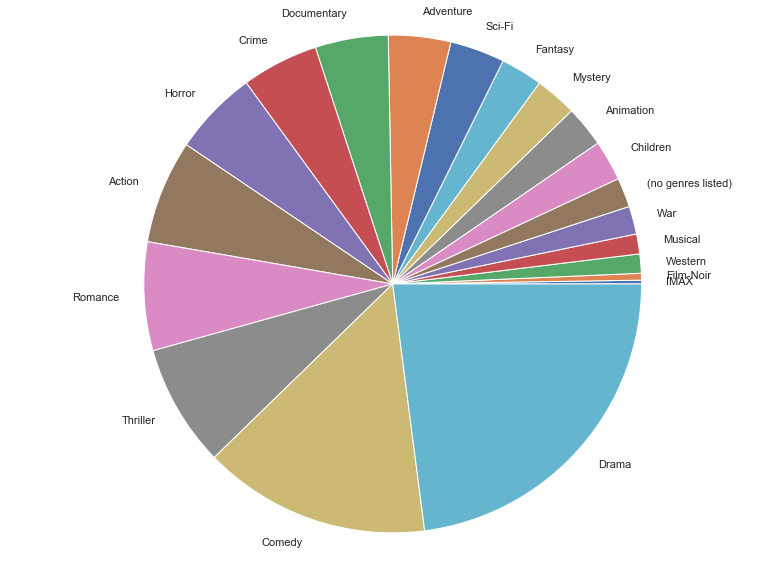

In [9]:
fig_pie,ax_pie = plt.subplots(figsize=(11,8))
plt.pie(sortedNoOfMovies, radius=4, labels=sortedGenreVocab)
plt.axis('equal')
plt.tight_layout()
plt.show()


**As seen from the above pichart, genres such as  Drama, comedy have maximum number of movies in comparison to other genres. IMAX is the genre with lowest percentage of the movies which is obvious as the technology is new and adopted by few blockblusters due to its cost.**

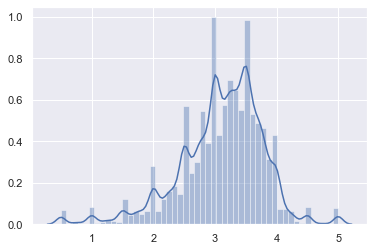

In [10]:
ax = sns.distplot(dfMoviesRatingTags['rating'].values)

**The above histogram shows that there are maximum movies with ratings in the range 3 to 4.**

**Now we want to use tags for clustering the movies. However, the tags include long sentences with stop words as well. So, we will use CountVectorizer which will convert the 'tag' column to the vector of words. Since we have large dimension of data, we take the top 500 frequent token of tags.**

In [11]:
stpwords = list(STOPWORDS)
stpwords.extend(stopwords.words('english'))
stpwords.extend(['movie','movies','film','films',
                 'actor','actress','cinema',
                 'story','br','role',
                 'characters','character','director','bd','based'])

cntVectorizer = CountVectorizer(binary=True, stop_words=stpwords, min_df=5, max_df=0.99,max_features=500)
#cntVectorizer = TfidfVectorizer(binary=False, stop_words=stop_words, min_df=5, max_df=0.99,max_features=500)
data = cntVectorizer.fit_transform(dfMoviesRatingTags['tag'])#fit makes a dictionary and transform 
                                                            #the words into values of dictionary.
vocab = cntVectorizer.get_feature_names()


In [12]:
totalTags = data.sum(axis=0)
totalTags = np.squeeze(np.asarray(totalTags))

def getDict(vocab, totalTags, number):
    dictionary = {}
    sortedIndices = np.argsort(-1*totalTags)[0:number]
    for index in sortedIndices:
        dictionary[vocab[index]] = totalTags[index]
    return dictionary
    

In [13]:
def wordCloudFromFrequency(dictionary):
    return WordCloud(stopwords=stpwords, background_color="white",width=800,height=800).\
                                                generate_from_frequencies(dictionary)

def plotWordCloud(wordcloud):
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

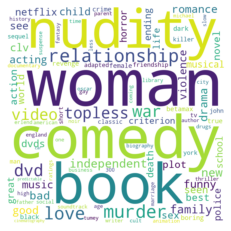

In [14]:
wordCloudFromTags = wordCloudFromFrequency(getDict(vocab, totalTags,100))
plotWordCloud(wordCloudFromTags)

**The above wordcloud shows the top 100 words that are used in the tag section. From this wordcloud, we can say that woman, comedy, book are the most pronounced words for tags. Also, there are more movies of genre comedy as seen from pie chart, so it can be related to the most frequently used tag in wordcloud. Similarly, the dramas are mostly based on books/novels, both genre drama and word 'book' occur predominantly in genre and wordcloud respectively.**

**Now we will cluster the movie and visualize the result.**

**For dimensionality reduction and converting categorical data to numbers, we use PCA. We compress 500 tokens to 50 principal components.**

In [15]:
pca = PCA(n_components=50, random_state=6)
principalComponents = pca.fit_transform(data.toarray())

**Now, we add the ratings to  the array principalComponents for the clustering.**

In [16]:
pcaWithRating = np.column_stack((principalComponents, dfMoviesRatingTags['rating'].values))
pcaWithRating.shape

(41772, 51)

**Before applying clustering algorithm, we want to check how all movies are clustered in a 2 dimensional space based on first two principal components.**

Text(0, 0.5, 'PCA 2')

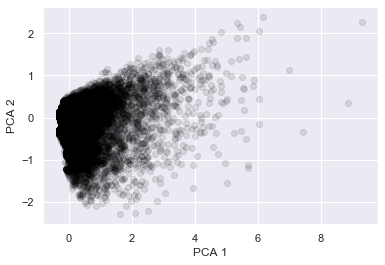

In [17]:
plt.scatter(pcaWithRating[:,0], pcaWithRating[:,1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

**Based on the 2 components, we obtain some clusters in the scatter plot. Now we are going to use KMeans model for clustering and inorder to select the hyperparameter k, we will use inertia as a metric.**

In [18]:
ks = range(3, 15)
inertiaList = []
for k in ks:
    kmeansModel = KMeans(n_clusters=k,random_state=6,max_iter=50,tol=0.01)
    kmeansModel.fit(pcaWithRating) 
    inertiaList.append(kmeansModel.inertia_)



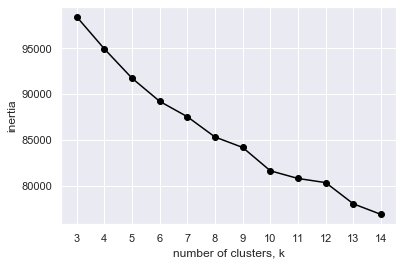

In [19]:
plt.plot(ks, inertiaList, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

**As seen in the graph above,  12 seems to be the good value.**

In [20]:
kmeansModel = KMeans(n_clusters=12,random_state=6,verbose=0,max_iter=50,tol=0.001)
kmeansModel.fit(pcaWithRating)

dump(kmeansModel, '../models/kmeans.joblib')

['../models/kmeans.joblib']

**Now, lets obtain the prediction for the features.**

In [21]:
loadedModel = load('../models/kmeans.joblib')
clusters = loadedModel.predict(pcaWithRating)
clusters

array([6, 3, 3, ..., 2, 7, 8], dtype=int32)

**We are going to join the cluster back to the main dataframe.**

In [22]:
dfMoviesRatingTags['cluster'] = clusters


**lets visualize the count and the average rating in each cluster using bardiagram.**

In [23]:
avgRatingPerCluster = dfMoviesRatingTags.groupby('cluster').agg({'rating':['count','mean']}).reset_index()


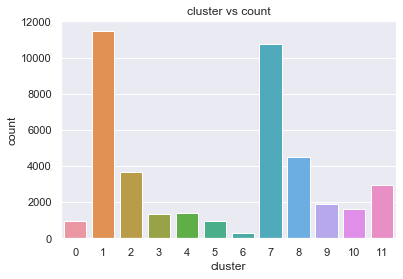

In [24]:
sns.barplot(x=avgRatingPerCluster['cluster'], y=avgRatingPerCluster['rating']['count'])
plt.title("cluster vs count")
plt.show()

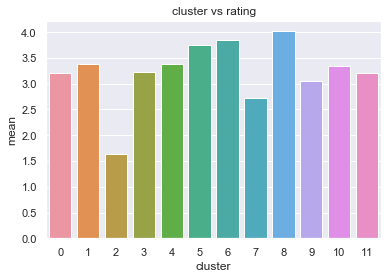

In [25]:
sns.barplot(x=avgRatingPerCluster['cluster'], y=avgRatingPerCluster['rating']['mean'])
plt.title("cluster vs rating")
plt.show()

**The mean rating for each cluster seems to be almost uniform whereas the number of movies in each cluster are not distributed uniformly as shown in the two bardiagrams above.**

Text(0.5, 1.0, 'pca1 vs pca2')

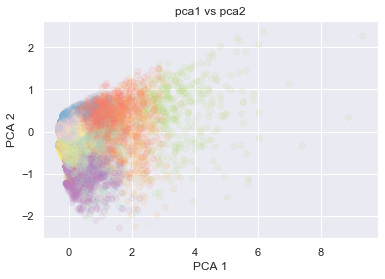

In [26]:
plt.scatter(pcaWithRating[:,0], pcaWithRating[:,1], alpha=.1, c=dfMoviesRatingTags['cluster'].values, cmap=plt.cm.Set3)

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title("pca1 vs pca2")

**We can see different colored clusters and overlapping between them when seen on 2D and some of the data are seen as outliers.**

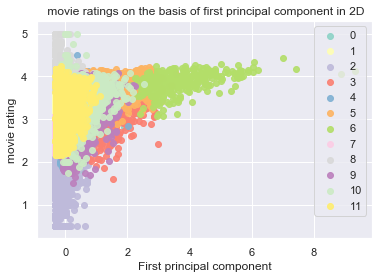

In [27]:
set3Colors = list(plt.cm.Set3.colors)

fig, ax = plt.subplots()
for key,color in enumerate(set3Colors):
    indices = dfMoviesRatingTags[dfMoviesRatingTags['cluster']==key].index
    ax.scatter(pcaWithRating[indices,0], pcaWithRating[indices,50],  c=[set3Colors[key]], label=key,
               alpha=0.9)
    

ax.legend()
ax.grid(True)
plt.xlabel('First principal component')
plt.ylabel('movie rating')
plt.title(" movie ratings on the basis of first principal component in 2D")
plt.show()

**We plotted the cluster of movies based on first principal component and movie rating. We can see some clusters although some overlapping takes place which may be due to projection on 2D.**

**Lets see what happens on 3D.**

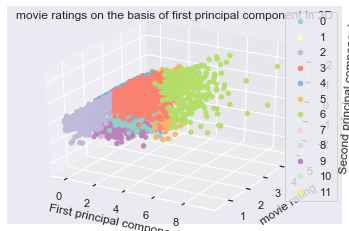

In [28]:
ax = plt.subplot(111, projection='3d')
for key,color in enumerate(set3Colors):
    indices = dfMoviesRatingTags[dfMoviesRatingTags['cluster']==key].index
    ax.scatter(pcaWithRating[indices,0], pcaWithRating[indices,50], pcaWithRating[indices,1],  
               c=[set3Colors[key]], label=key,
               alpha=0.9)
    

ax.legend()
ax.grid(True)
ax.set_xlabel('First principal component')
ax.set_ylabel('movie rating')
ax.set_zlabel('Second principal component')
plt.title("movie ratings on the basis of first principal component in 2D")
plt.show()

**On 3D, the some points which were supposed to be outliers are also seen in clusters. Now lets see the significant tags which may be responsible for clustering the movies.**


**Now, the result of clustering is visualized using pyLDAvis library where we can observe the important tags for each cluster in an interactive way.**

**For using pyLDAvis, we need to generate the arguments such as distribution of tags for each cluster, tag frequency and so on.**


In [29]:
topicTerm = []
for i in range(12):
    indices = dfMoviesRatingTags[dfMoviesRatingTags['cluster']==i].index
    cluster = data[indices]
    clusterColumnSum = cluster.sum(axis=0)
    clusterColumnSum = np.squeeze(np.asarray(clusterColumnSum))
    topicTerm.append(clusterColumnSum/clusterColumnSum.sum())

In [30]:
clusterTermDist = np.array(topicTerm)
docClusterDist = pd.get_dummies(dfMoviesRatingTags['cluster'])
docLength = data.sum(axis=1)
docLength = np.squeeze(np.asarray(docLength))
nonZeroDocLength = np.where(docLength!=0)[0]
docLength = docLength[nonZeroDocLength]
docClusterDist = docClusterDist.values[nonZeroDocLength,:]
vocabArray = np.array(vocab)
termFreq = clusterTermDist.sum(axis=0)#matrix


In [31]:
ldaVisData = {'topic_term_dists': clusterTermDist, 
            'doc_topic_dists': docClusterDist,
            'doc_lengths': docLength,
            'vocab': vocabArray,
            'term_frequency': termFreq,
            'sort_topics':False
             }
pyLDAvis.prepare(**ldaVisData)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.000663  0.048106       1        1   4.205043
1      0.007427 -0.035486       2        1  17.982208
2      0.086392 -0.011161       3        1   3.906768
3     -0.028247  0.035268       4        1  12.033548
4     -0.091661 -0.123099       5        1   4.572553
5     -0.072354  0.031320       6        1  10.844190
6     -0.085963  0.060036       7        1   7.448270
7      0.049252 -0.021663       8        1  12.436986
8      0.005664 -0.036543       9        1   5.865952
9      0.022470  0.052065      10        1   8.339352
10     0.027856  0.030571      11        1   7.481203
11     0.079828 -0.029413      12        1   4.883927, topic_info=    Category    Freq          Term   Total  loglift  logprob
491  Default  4023.0         woman  4023.0  30.0000  30.0000
480  Default  2036.0           war  2036.0  29.0000  29.0000
315  Default  2612.0        nudity  2612.0  28.0000  28.0000
460  Default  1851.0       topless  1851.0  27.0000  27.0000
371  Default  2488.0  relationship  2488.0  26.0000  26.0000
..       ...     ...           ...     ...      ...      ...
298  Topic12    73.0        murder  2434.0  -0.4876  -5.1861
307  Topic12    59.0       netflix  1313.0  -0.0833  -5.3990
314  Topic12    58.0         novel  1226.0  -0.0318  -5.4161
197  Topic12    55.0         funny  1553.0  -0.3214  -5.4692
480  Topic12    53.0           war  2036.0  -0.6292  -5.5063

[665 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         1  0.033435      01
0         2  0.449848      01
0         3  0.003040      01
0         4  0.021277      01
0         5  0.109422      01
...     ...       ...     ...
499       8  0.326220  zombie
499       9  0.018293  zombie
499      10  0.085366  zombie
499      11  0.021341  zombie
499      12  0.018293  zombie

[3946 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

**pyLDAvis library provides multidimensional scaling to help visualize high dimensional features in 2D space. By inspecting the above clusters, we can see that the cluster 5 contains the movies related to war and military. Similarly, the cluster 6 and 7 seem to have similar tags related to movies with tags such as great, best, top, oscar and so on. In the same manner, cluster 3 and 8 contain mostly horror movies.**

**With the help of this visualization, we can get insights about the tag distribution for each cluster and also verify the validity of the clustering algorithm.**